In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points', 'worst radius', 'mean perimeter', 'worst concave points', 'mean area', 'worst area', 'mean concavity']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

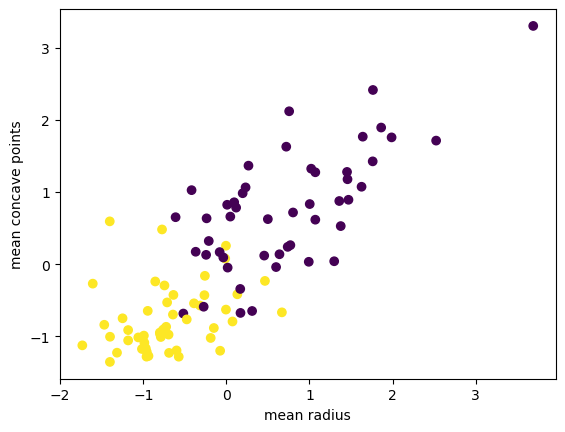

In [3]:
n = 100
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.019860506057739258
Optimal objective value: 134.41185727427032
SCS solver iterations: 850
SCS solve time: 0.0069219929999999995
SCS setup time: 0.001943297
Optimal w:  [ 1.59891047 -1.34084505 -3.62931426  0.76481952 -0.78423755  1.34474409
 -3.60745296 -0.0464193 ]
Optimal b:  [-0.99604605]
Dual variables (Lagrange multipliers): [-0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         10.00000003  0.          4.44452692  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.          9.99999998 10.00000003
  0.          0.          0.          0.          0.          0.
  0.         -0.         10.00000002 10.00000003 10.00000001  0.
  0.          5.30554135  5.59355117  0.          0.          0.
  

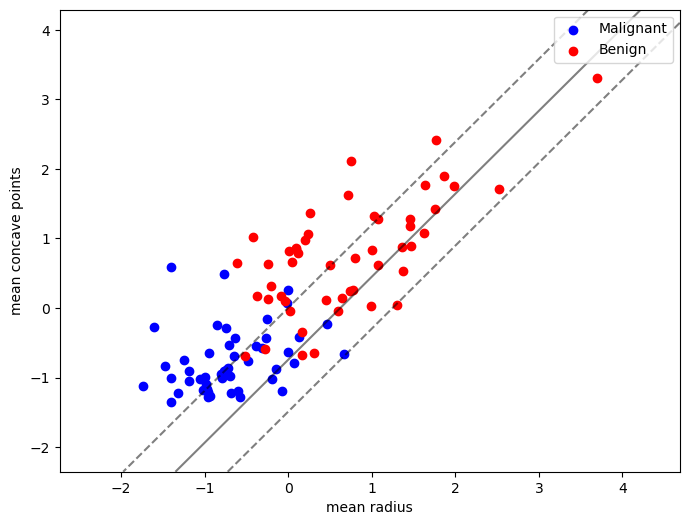

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 15.155142545700073


objective: 111.91259 lim: 1
objective: 111.91259
w:  [ 1.64747028 -1.45096971 -3.40986905  1.0786681  -0.47199345  1.13265571
 -3.4528302   0.09835018] b:  -1.0217948805887707
hyperplane similarity: 0.008032662877764982
Dual variables (alpha): [ 1.64747028 -1.45096971 -3.40986905  1.0786681  -0.47199345  1.13265571
 -3.4528302   0.09835018 -1.02179488  0.00049227  0.00049381  0.00049373
  0.00049386  0.00049387  0.00049387  0.05701633  0.0004936   0.00049395
  0.00026616  0.00049396  0.00049386  0.00049362  0.00049384  0.0004937
  0.00049396  0.00049335  0.00049361  0.00049388  0.11151708  0.00049365
  0.11851901  0.00049388  0.00049388  0.00049374  0.00049396 -0.24596622
  0.00049379 -0.01340001  0.00049369  0.0004205   0.00048245  0.00049365
  0.00049387  0.00049367 -0.16245984  0.00048928  0.00049374  0.00049386
  0.00049383  0.1760511   0.93803069  0.00049389  0.00049374  0.00049389
  0.00049395  0.00049029 -0.00017622  0.00049363  0.00049388  0.19030781
  0.20740427  0.34259174  0

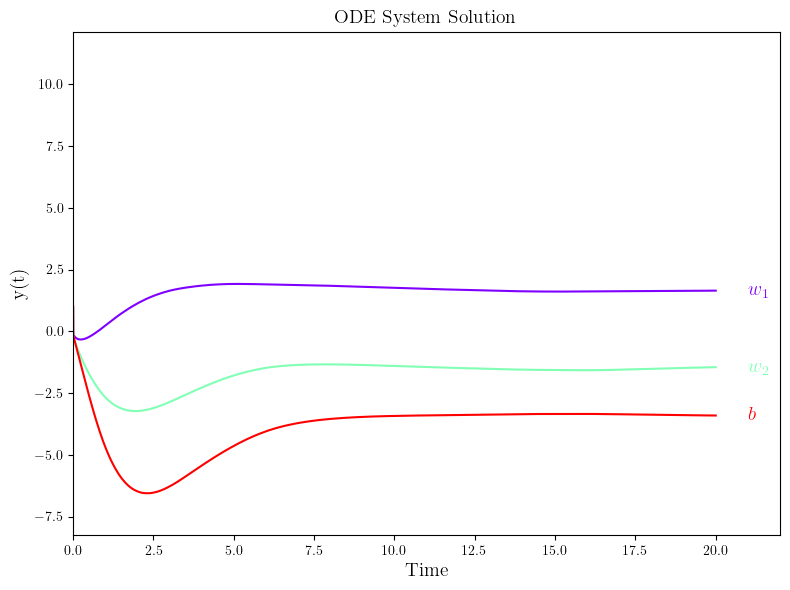

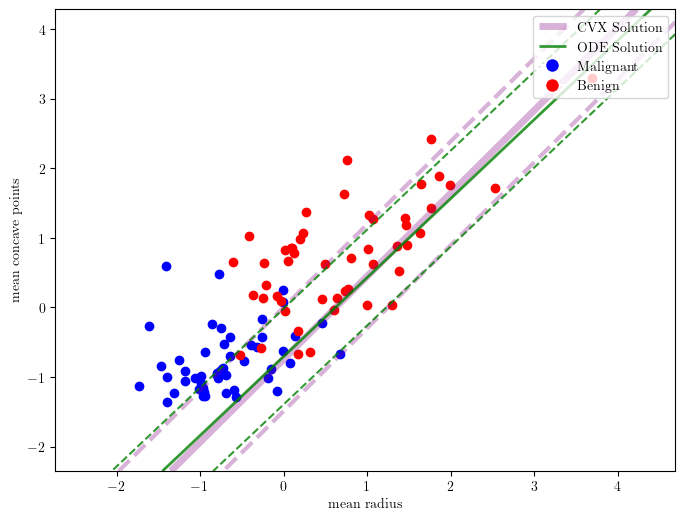

epsilon: inf time: 1321.8287155628204 iterations: 2000


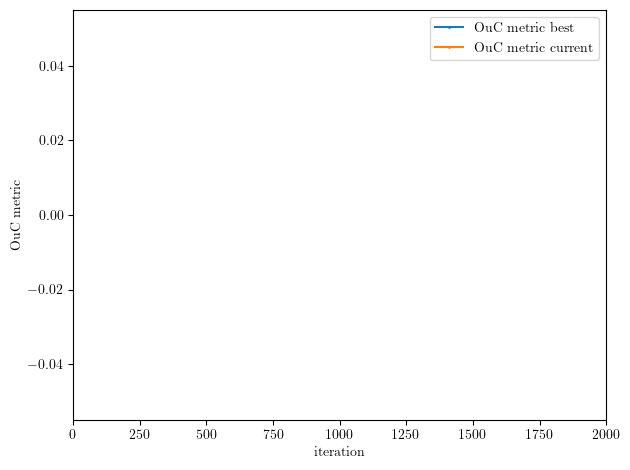

Last losses: [3151.7802734375, 1110.468994140625, 1098.7333984375, 1002.84228515625, 951.7997436523438, 3103.7080078125, 2744.6904296875, 6184.54345703125, 1652.09423828125, 1901.12548828125]


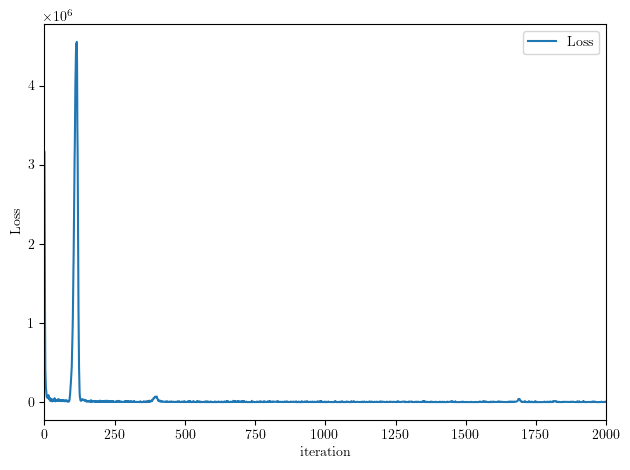

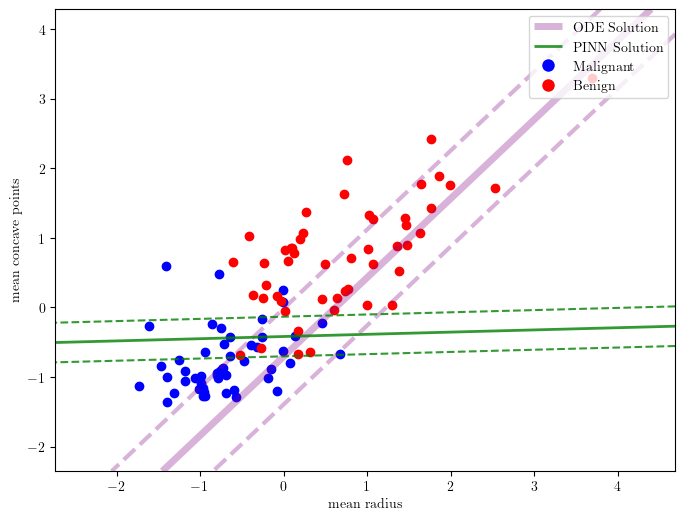

Variables: [ 0.11096472 -3.5102544  -7.574044   -0.34339356 -3.1235113  -0.122504
 -6.779726   -1.2356882  -1.4663081  -0.9624754  -1.1170818  -1.0535518
 -0.18097465 -0.4674363  -1.2027645  -1.4788799  -1.0453725  -0.39676654
 -0.24358927  0.38512322 -1.55704    -0.998068   -1.2278355  -1.046238
 -1.526961   -0.94535    -0.9697183  -1.545834   -1.038553   -1.0920154
 -1.6378099  -1.1453149  -1.5726635  -0.97654074 -1.3975292  -1.3302225
 -1.291297   -0.02602525 -1.0577389  -0.00213611  0.09168047 -1.1317731
 -1.192852   -1.1123147  -2.3805766  -0.85522646 -1.2049898  -1.0841235
 -1.1534     -1.5028291  -0.43455878  0.04599387 -1.1661339  -2.163441
 -0.89593315 -0.9792126  -0.56187755 -1.0783894  -0.35654682 -0.8625663
 -1.0032338  -0.96991605 -1.2549118  -0.7010899  -1.6657944  -0.43418264
 -1.0846429  -1.7214893  -1.5959027  -1.1075583  -1.1825405  -1.0467691
 -0.1924912  -1.0394225   0.7811624  -1.2380906  -1.0786651  -0.8559047
 -1.2702976  -0.87988096 -1.0999782  -0.4162981  -0.56

Time: 3.163989305496216
objective: 112.5409 lim: 1
objective: 112.5409
w:  [ 1.64092336 -1.44377524 -3.33123685  0.94209079 -0.45731441  1.17423026
 -3.40319866  0.09090618] b:  -1.0201705882251952
hyperplane similarity: 0.009027464795813428
Dual variables (alpha): [ 1.64092336 -1.44377524 -3.33123685  0.94209079 -0.45731441  1.17423026
 -3.40319866  0.09090618 -1.02017059  0.00002848  0.00002884  0.0000289
  0.00701356  0.00004925  0.00003699  0.07478099  0.00003183 -0.00018963
  0.00002972 -0.00024414  0.00004258  0.00002981  0.0000375   0.00003021
  0.00004617  0.00002483  0.00002782  0.00003597  0.12932901  0.00003625
  0.09265296  0.0000368   0.00004177  0.00002891  0.00004276 -0.23172701
  0.00003814 -0.02495242  0.0000345  -0.00001001  0.00005966  0.00003789
  0.00003766  0.00002793 -0.14176199  0.00002967  0.00003896  0.0000363
  0.00003725  0.18456164  0.96503412  0.00155566  0.00003806  0.00004624
  0.00003141 -0.00000168  0.00001987  0.00003574  0.00007704  0.20677157
  0.22

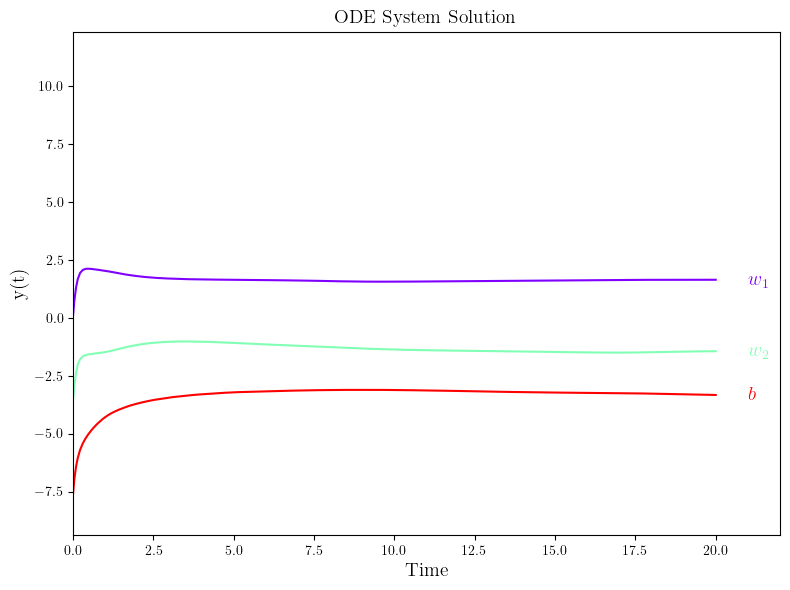

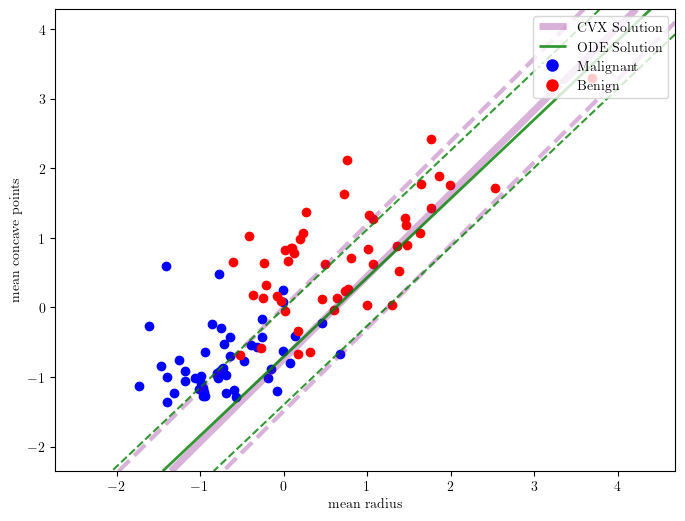

epsilon: inf time: 6389.842446088791 iterations: 10000


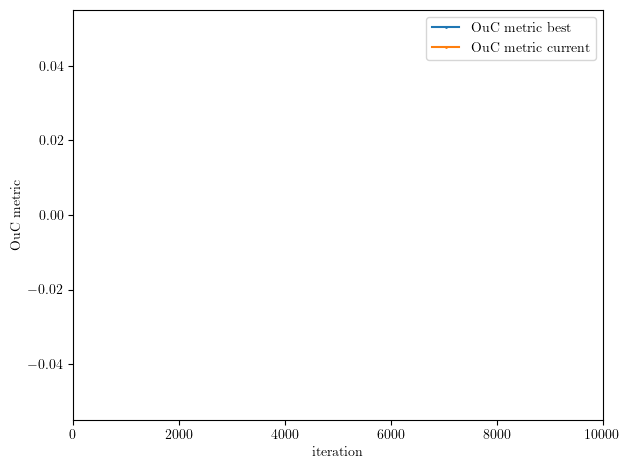

Last losses: [35.57328796386719, 31.068674087524414, 33.92128372192383, 30.428482055664062, 33.42115020751953, 29.387298583984375, 31.322298049926758, 34.32741928100586, 32.545204162597656, 36.63759231567383]


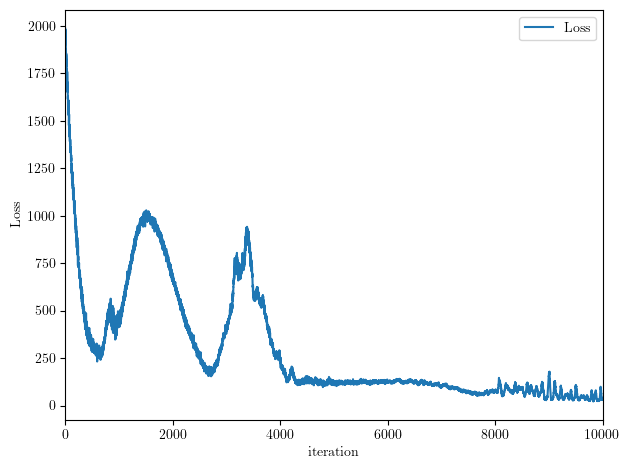

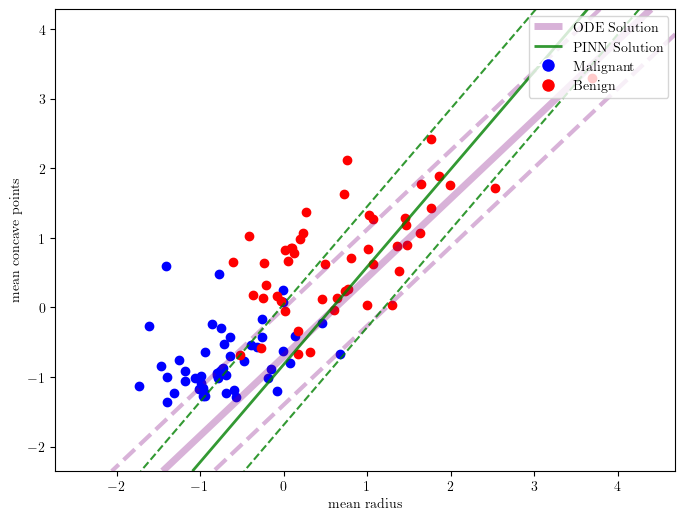

Variables: [ 1.6169393  -1.1517134  -3.1743617   1.2071879  -0.35778284  1.303226
 -3.2258193  -0.04325938 -0.9438794  -0.05699742 -0.09176672 -0.0672316
  0.02269094  0.07972878 -0.0907445  -0.19210136 -0.0558095   0.0242995
  0.06920154  0.14220962 -0.15661061 -0.08894342 -0.08992326 -0.08811879
 -0.12156081 -0.0805406  -0.06484222 -0.16969395 -0.14754355 -0.07049417
  0.382326   -0.05528414 -0.13880849 -0.07990777 -0.08406615 -0.41590285
 -0.11526835  0.03723502 -0.05893987  0.17291673  0.25442177 -0.05202127
 -0.06645882 -0.11034036 -0.39632714 -0.02515054 -0.07253587 -0.04401624
 -0.07087982  0.11143279  0.5097333   0.0824018  -0.05843794 -0.26722312
 -0.05002755 -0.21047878 -0.05443567 -0.04347444  0.19629997 -0.09183598
 -0.01647806  0.0704847  -0.05720294  0.02410221  0.33099842  0.34296012
 -0.08110654 -0.46111894  0.17240477 -0.09414291  0.18075097 -0.07907093
  0.09568277 -0.08174896  0.85076004 -0.08262348  0.24114347  0.00738251
 -0.06845522  0.04665184 -0.05682027  0.3426

Time: 2.864531993865967
objective: 124.275215 lim: 1
objective: 124.275215
w:  [ 1.63601381 -1.51157424 -3.45371608  0.82335856 -0.63730422  1.19404631
 -3.49685553  0.02109241] b:  -0.946280549440873
hyperplane similarity: 0.0025980133678865647
Dual variables (alpha): [ 1.63601381 -1.51157424 -3.45371608  0.82335856 -0.63730422  1.19404631
 -3.49685553  0.02109241 -0.94628055  0.00000353  0.00000375  0.00000419
  0.00002211 -0.00000132  0.00000462 -0.04000748  0.00000429  0.00000198
 -0.00000213  0.00000201  0.00000583  0.00000414  0.00000522  0.00000359
  0.00000675  0.00000312  0.00000443  0.00000663  0.07469605  0.00000401
  0.0161922   0.00000505  0.00000572  0.00000379  0.00000491  0.00284267
  0.00000615 -0.00013167  0.00000274 -0.00000515 -0.00000703  0.00000373
  0.00000412  0.00000383 -0.27799692  0.00000241  0.00000422  0.00000322
  0.00000424  0.07623327  0.88495086  0.00001129  0.00000429  0.00001306
  0.00000325  0.0000069   0.00000128  0.00000362 -0.00000599  0.13251071


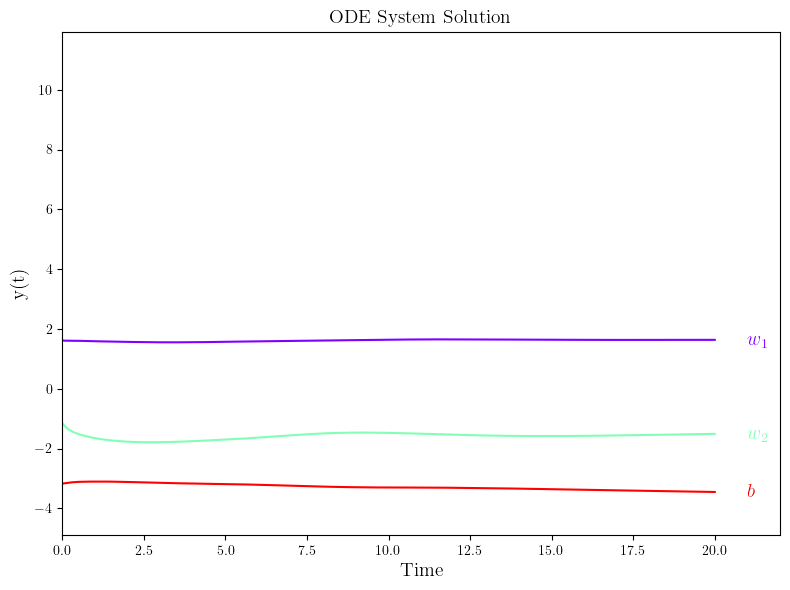

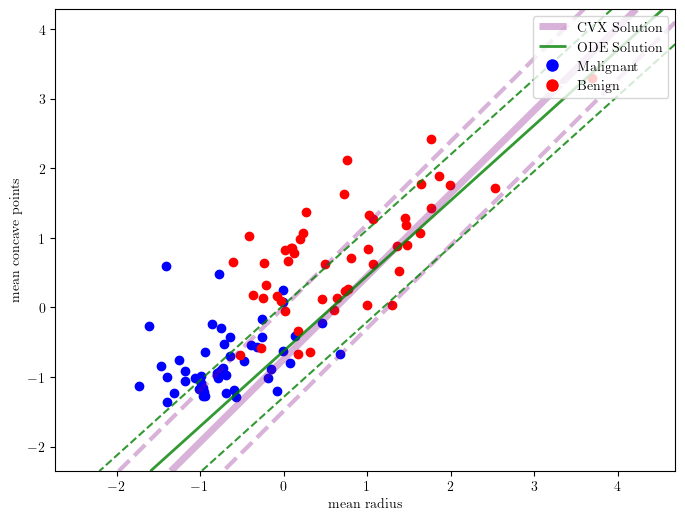

epsilon: inf time: 6310.018835067749 iterations: 10000


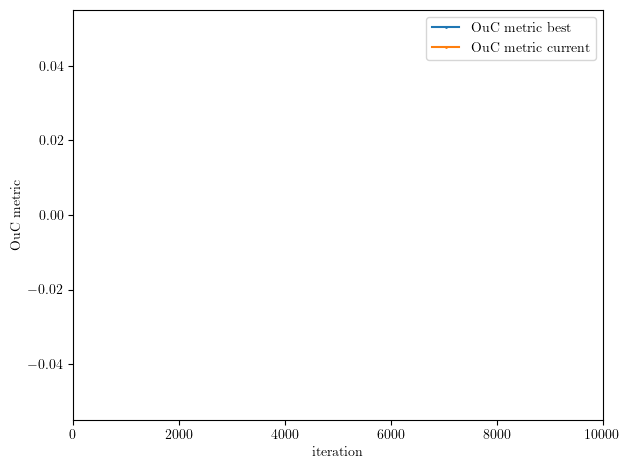

Last losses: [0.20965296030044556, 0.2047261893749237, 0.19668088853359222, 0.1792568564414978, 0.14976051449775696, 0.1251949518918991, 0.12605983018875122, 0.11488403379917145, 0.1188274621963501, 0.1358875334262848]


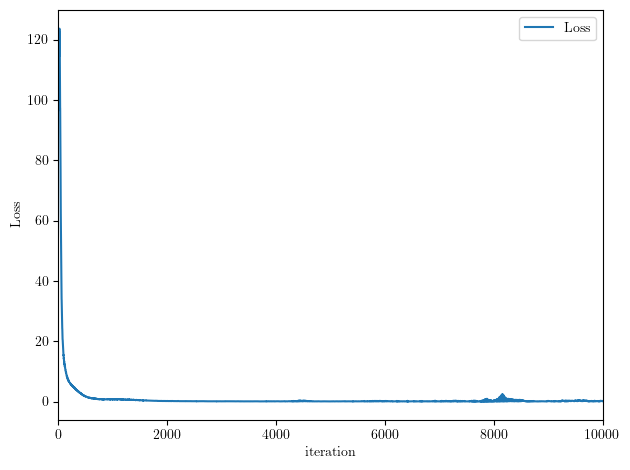

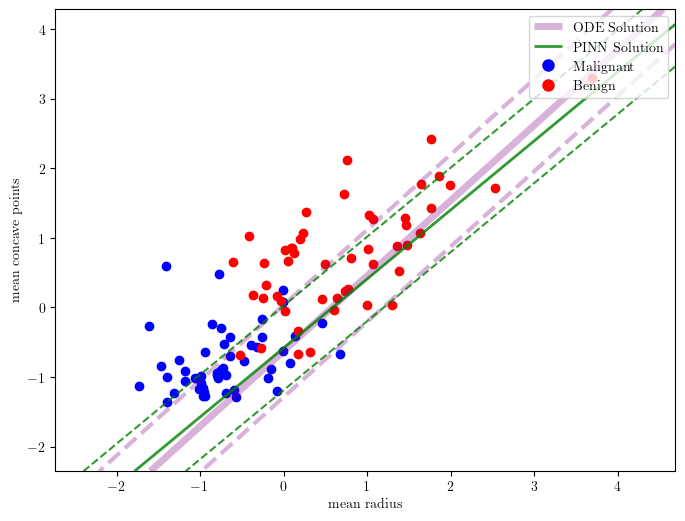

Variables: [ 1.6359193  -1.6482978  -3.4088254   0.8149431  -0.6002061   1.1977546
 -3.4563305   0.08948547 -0.9583054  -0.01444749  0.00613885 -0.01488283
  0.02508268 -0.00105533  0.0135563  -0.08458568  0.02306513 -0.02933777
 -0.03697781  0.02219662 -0.01247816 -0.02165076 -0.01436546  0.00161546
 -0.00418333  0.01350521  0.03327712  0.02705541  0.05849274 -0.01654955
 -0.01798776 -0.02897434  0.00465292 -0.0086551   0.01607961  0.102391
  0.02071282 -0.06797622  0.0060316   0.02898274  0.0209861   0.00579972
  0.01355916 -0.00969609 -0.34330457  0.00598511 -0.00592067 -0.00258526
 -0.00357116  0.05976782  0.8286874   0.01494257  0.006138   -0.02205561
  0.00212163  0.00531301 -0.01435344 -0.01166401 -0.01422977  0.12576261
  0.13116589  0.6386261   0.00611784  0.02174327  0.02098218  0.02016366
 -0.00819486 -0.08306992  0.0349465   0.00030653  0.0127449   0.03379637
  0.01473561 -0.0215756   1.7735326  -0.01638386 -0.03529626 -0.02358551
  0.01316886  0.10562901 -0.00289348  0.161

Time: 2.6604583263397217
objective: 129.1582 lim: 1
objective: 129.1582
w:  [ 1.69173596 -1.53495402 -3.6894301   0.88845691 -0.76880657  1.24873882
 -3.66632193 -0.01624177] b:  -0.9574280837316368
hyperplane similarity: 0.005735695221697951
Dual variables (alpha): [ 1.69173596 -1.53495402 -3.6894301   0.88845691 -0.76880657  1.24873882
 -3.66632193 -0.01624177 -0.95742808 -0.00000028 -0.00000048 -0.00000021
 -0.00000217  0.00000048  0.0000002  -0.09514008 -0.00000003  0.00000018
  0.00000119 -0.00000143  0.00000098 -0.00000005  0.00000045  0.00000048
 -0.0000005   0.00000092 -0.00000147 -0.0000001   0.0459218   0.00000136
 -0.01201159  0.00000047  0.00000049  0.00000043  0.00000025 -0.0000047
 -0.00000143  0.00000381 -0.00000144 -0.00000028 -0.00000139 -0.0000014
 -0.00000144  0.00000047  0.00002306 -0.00000045  0.00000044 -0.00000037
  0.00000047  0.04213578  0.83396754 -0.00000143  0.00000048  0.00000028
  0.00000119  0.0000007  -0.00000027 -0.00000046 -0.00000034  0.11128232
  0.2

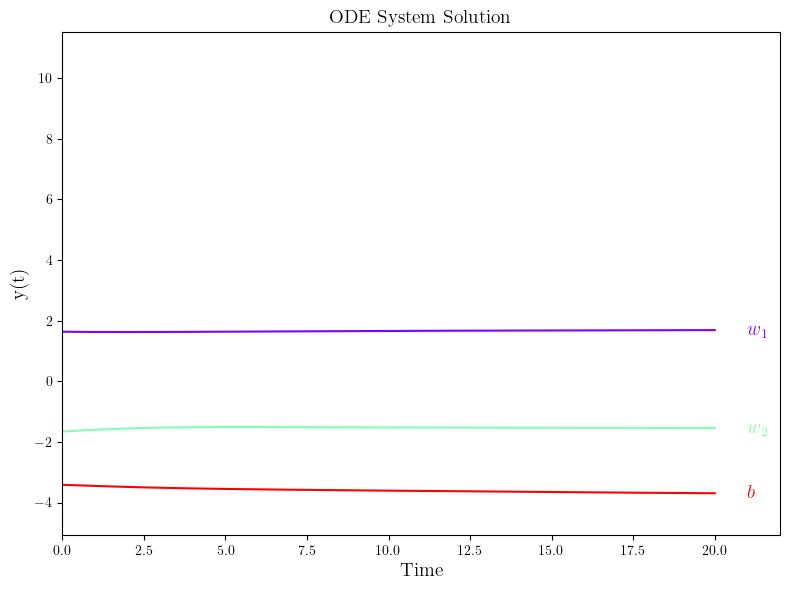

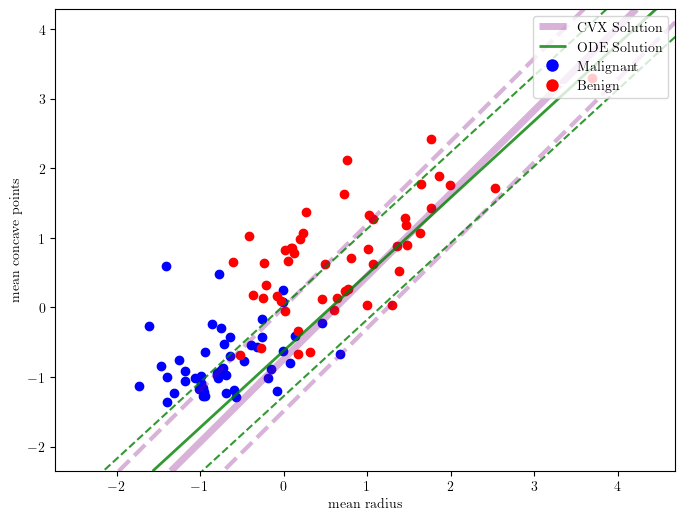

epsilon: inf time: 6315.38397359848 iterations: 10000


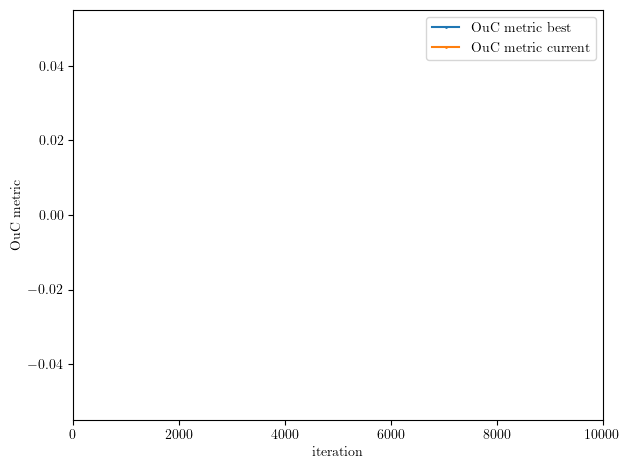

Last losses: [0.016267383471131325, 0.017595047131180763, 0.02017775923013687, 0.022451508790254593, 0.023227959871292114, 0.02294914424419403, 0.02186020277440548, 0.02038099616765976, 0.01721528172492981, 0.01733473502099514]


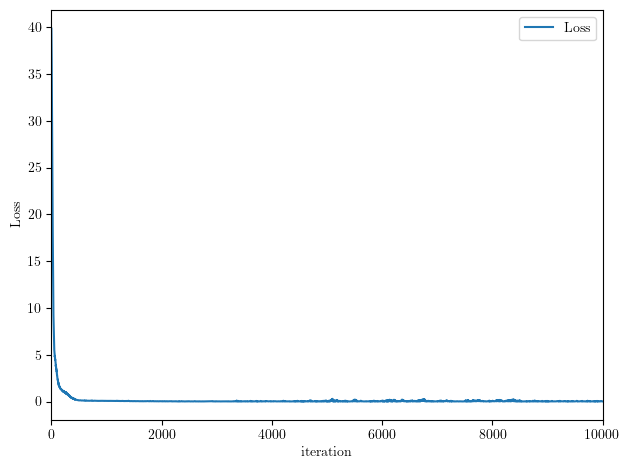

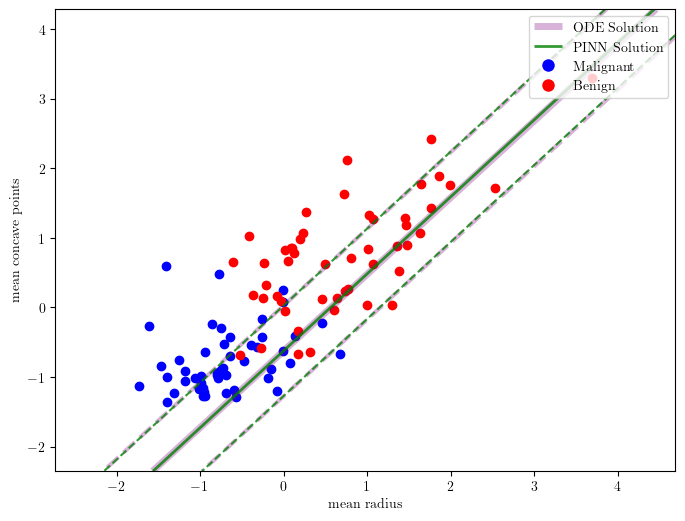

Variables: [ 1.703697   -1.5394428  -3.6873398   0.896912   -0.7619736   1.2580204
 -3.6665998  -0.00794464 -0.9572983  -0.00326739  0.00167523  0.01385815
  0.00004097 -0.0001877   0.00352552 -0.09457588  0.01495753  0.00293348
  0.00300875  0.00886044 -0.00103937  0.0097616   0.00240847 -0.00018247
  0.00196252  0.00366174  0.00952785 -0.0015045   0.05697096  0.00377243
 -0.01340243 -0.00292961 -0.01205928  0.00424414 -0.00516001 -0.00182142
 -0.00462556  0.0070663  -0.00150584  0.00421933  0.00802515  0.01198708
  0.01187318 -0.00091301 -0.01086834 -0.00377454 -0.00551214  0.00367987
 -0.00351731  0.0497382   0.8315286  -0.00702557 -0.00183743  0.00216184
  0.00482617 -0.0098469   0.00350909  0.01412451  0.01017115  0.11873417
  0.2248844   0.42792913 -0.01395765 -0.00506602  0.01190568 -0.00120862
  0.00467066 -0.0016439   0.00278807 -0.00514135  0.00255819  0.00051109
  0.00160102 -0.01016832  1.769305   -0.00057381 -0.00090127 -0.00597627
 -0.01162074  0.06226794 -0.00066302  0.1

Time: 2.690190076828003
objective: 130.36163 lim: 1
objective: 130.36163
w:  [ 1.72955454 -1.56689733 -3.76355794  0.94882466 -0.75130304  1.2875523
 -3.73906259  0.0066704 ] b:  -1.019935706282818
hyperplane similarity: 0.0023384928562978774
Dual variables (alpha): [ 1.72955454 -1.56689733 -3.76355794  0.94882466 -0.75130304  1.2875523
 -3.73906259  0.0066704  -1.01993571  0.00000042  0.00000047 -0.00000045
 -0.00000047 -0.00000037  0.00000044 -0.07577666 -0.00000045 -0.00000044
  0.00000053  0.00000047 -0.00000044 -0.00000047 -0.00000047  0.00000044
 -0.00000046  0.0000005  -0.00000044  0.00000046  0.05768418 -0.00000046
 -0.01894249  0.00000047  0.00000044  0.00000049  0.00000045  0.00000044
 -0.00000054 -0.00000047  0.00000053 -0.00000044 -0.00000046 -0.00000044
  0.00000007  0.00000042  0.00000044 -0.00000047  0.00000044 -0.00000043
 -0.00000046  0.06851217  0.86874769  0.00000045  0.00000044 -0.00000044
  0.00000052  0.00000047 -0.00000042  0.0000003  -0.00000047  0.23632149
  0.

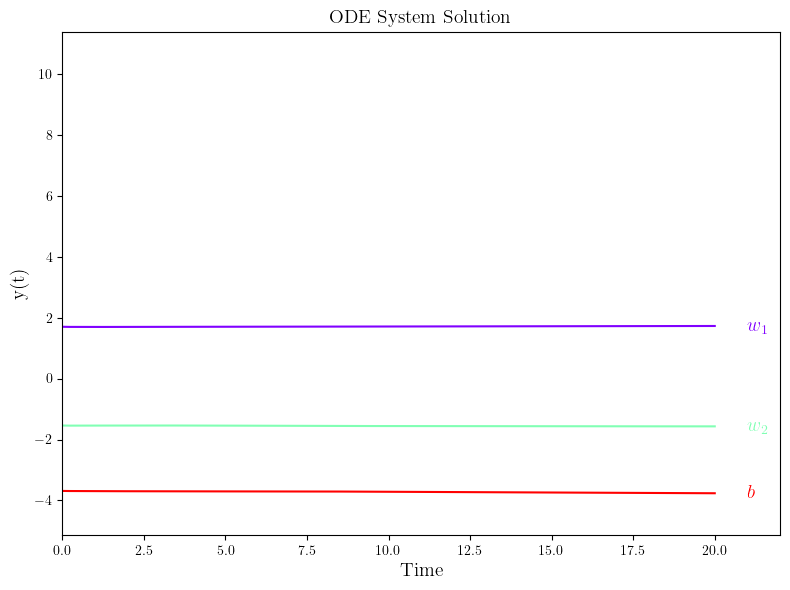

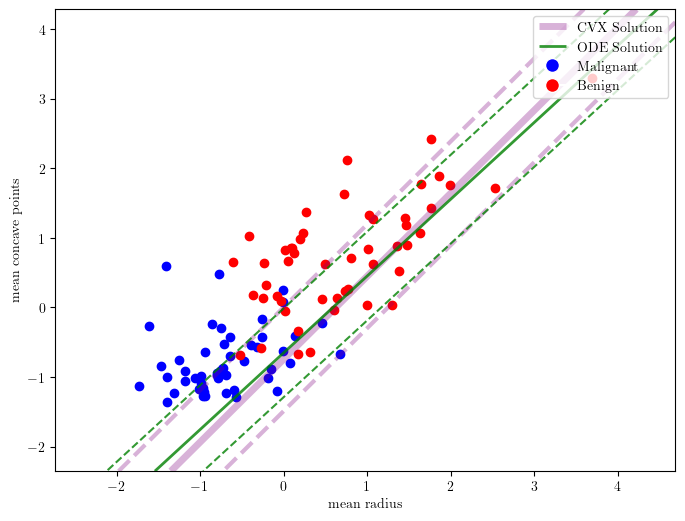

epsilon: inf time: 1946.6127982139587 iterations: 3070


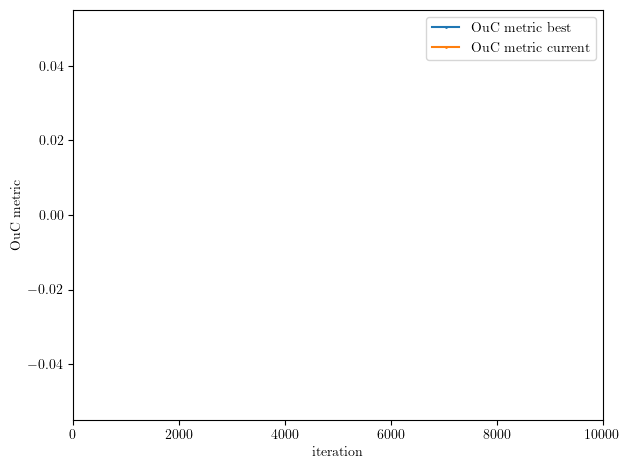

Last losses: [0.010978138074278831, 0.010906902141869068, 0.010590991005301476, 0.010348491370677948, 0.010639769956469536, 0.009929104708135128, 0.009545208886265755, 0.009586126543581486, 0.0099767055362463, 0.009700438007712364]


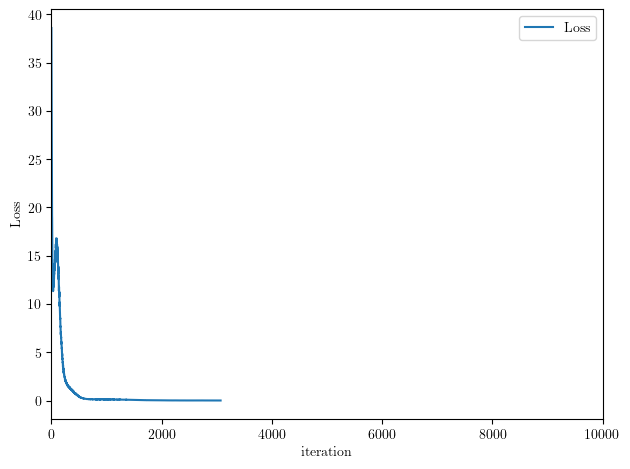

>>> NN Solution is accurate, last iteration


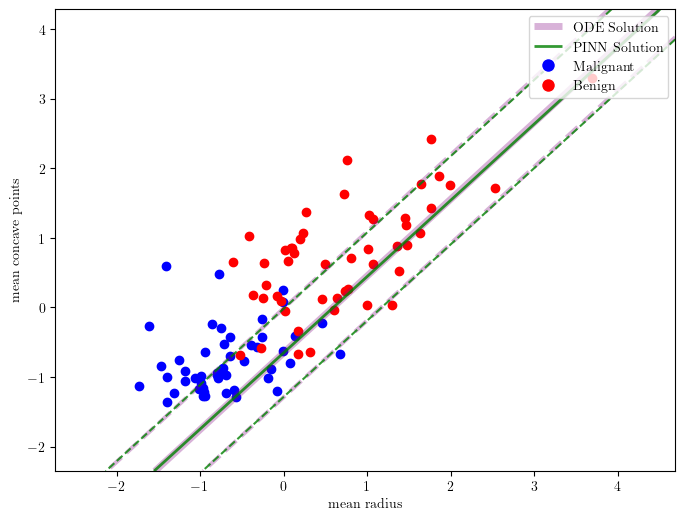

Variables: [ 1.7292728  -1.57727    -3.730579    0.93439156 -0.7420557   1.2842607
 -3.7156997   0.01022304 -1.0267117  -0.0008615  -0.01100826 -0.00241736
 -0.012194    0.00896349 -0.00392797 -0.09430277  0.01440229 -0.00445495
 -0.00694035 -0.00899735 -0.00283374 -0.0024894  -0.00335957 -0.01516834
 -0.00844036  0.00866299  0.00500011 -0.01428409  0.04130105  0.00724271
 -0.0234722  -0.00565833  0.01044549 -0.00355305 -0.00163959 -0.00057105
  0.00834767  0.00318301  0.00706623 -0.01387023  0.00112     0.00660033
 -0.00368512 -0.00834771 -0.00941939  0.00323239  0.01267683 -0.0077035
 -0.0052051   0.07827126  0.88910717  0.00507746 -0.00753871 -0.01134046
  0.00032471  0.00879151  0.0007291  -0.0058028  -0.01798261  0.2617901
  0.2834142   0.5000508   0.01187238 -0.00234314  0.00677913 -0.00524418
 -0.00834147 -0.00832545  0.00120547 -0.00476196 -0.00879295 -0.00273084
  0.00013796 -0.00421196  1.6786972  -0.02692568 -0.01021916 -0.01530516
  0.01467684 -0.03473736  0.00562388  0.129

In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(5):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.0001